In [99]:
#!/usr/bin/python
# coding=gbk

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import numpy as np
import pandas as pd
from pandas import Series,DataFrame  

# 总结

这次比赛并没有给出比较完整的训练集，需要根据业务理解确定训练集形式及特征。根据比赛网页中“所有测试集中会有部分数据的实际订单量为0”的说明，需要构建一个包含所有可能的完整的训练集。比赛中有5000个区域，按照<日期，小时时段，开始区域，结束区域>构建训练集，就会有31*24*5000*5000=18,600,000,000。显然这种构建训练集的方式存在严重的问题，会导致大量样本的label为0。一种处理方式是条件判断+模型预估的方式处理。想法如下：
* 在31天中没有出现过的<开始区域，结束区域>组合，可以认为因为某些客观因素（两地相距较远、费用较高，私人打车不会考虑）的原因，我们就认为这些区域单量会一直为0。这样可以将<开始区域，结束区域>简化到31831，对应的训练集就会只有31*24*31831，约为2400W。而总的订单数只有892518。<日期,时段,区域,区域>对的数量为501345，与2400W相比还是有两个数据量级的差距。
* 从单量-hour分布图可以看出，一天的单量主要集中在7~23。这个也比较符合常识，7点钟开始慢慢进入上班通勤时间，8点钟出现一次打车高峰，17点出现一次打车高峰，这与“早九晚五”的工作模式比较匹配。晚上21、22点出现另外一个高峰，晚上时段更倾向于打车作为出行方式有关。这里可以尝试两种方式：1）分段模型，或者2）将时段作为特征加入到模型。

feature 头脑风暴：
* 时段

以下特征分别有起止两个区域的特征：
* filling_station：加油站
* super_market：超市
* house：住宅区
* subway_station：地铁站
* bus_station：公交站
* coffee_shop：咖啡馆
* chinese_restaurant：中餐厅
* atm：atm机
* office_house：写字楼
* hotel：酒店

天气状况：
* date
* code
* temperature
* feels_like
* pressure
* humidity
* visibility
* wind_direction_degree
* wind_speed
* wind_scale

时间：
* 增加weekend字段（7月份、8月初没有特殊节日，不需要增加）


In [46]:
father_path="/Users/leidelong/competition/uai/UAI_Data/"
hash_poi_info=pd.read_csv(father_path+"poi.csv",encoding="gb2312",sep=';')
train_Aug=pd.read_csv(father_path+"train_Aug.csv",encoding="gb2312")
train_July=pd.read_csv(father_path+"train_July.csv",encoding="gb2312")
test_public=pd.read_csv(father_path+"test_id_Aug_agg_public5k.csv")

## 探区域内查POI信息

In [43]:
hash_poi_info.head(10)

,hash_id,filling_station,super_market,house,subway_station,bus_station,coffee_shop,chinese_restaurant,atm,office_house,hotel
0,829fd9e04ed5f0e2148096737edb8a73,0,0,1,0,2,0,0,0,0,0
1,3d99665144344fc090b5b7450ffe72f5,4,43,151,4,36,22,597,59,47,45
2,f524dc6b89fcb9e4a9688c0cb7b2bdb7,0,0,0,0,0,0,0,0,0,0
3,0613fd690240317177a03a0b26ca8591,4,32,50,3,22,6,509,20,9,27
4,687ea595a01fdc18ad438f0d0a325102,0,3,1,0,6,0,6,0,0,1
5,3bee6a7b93130a1359165736c6ea0850,0,0,0,0,0,0,0,0,0,0
6,370bd5250561d0feb3c70ac22f47a0a5,2,30,151,3,28,19,513,39,55,80
7,82dc208d41286f0eb9edb9783e9b65b0,0,0,0,0,0,0,0,0,0,0
8,f80c4ceeb36264b42e34d6c4c2cb9b4c,9,34,170,4,45,20,779,69,66,116
9,760471f16acb57036aa34172ff2d5e52,0,0,0,0,0,0,0,0,0,0


In [44]:
print poi_info.columns
print poi_info.shape

Index([u'hash_id', u'filling_station', u'super_market', u'house',
       u'subway_station', u'bus_station', u'coffee_shop',
       u'chinese_restaurant', u'atm', u'office_house', u'hotel'],
      dtype='object')
(1234, 11)


In [45]:
poi_info[poi_info['super_market']>0].shape

(738, 11)

这次比赛涉及区域数1234个
字段说明：
* hash_id:区域hash编码
* filling_station：加油站
* super_market：超市
* house：住宅区
* subway_station：地铁站
* bus_station：公交站
* coffee_shop：咖啡馆
* chinese_restaurant：中餐厅
* atm：atm机
* office_house：写字楼
* hotel：酒店


## 探索公开测试集

In [49]:
print test_public.columns
print test_public.shape

Index([u'test_id', u'start_geo_id', u'end_geo_id', u'create_date',
       u'create_hour'],
      dtype='object')
(5000, 5)


公开测试集有5000个<区域，区域>对，字段如下：

* test_id：唯一标示
* start_geo_id：起始geohash
* end_geo_id：终止geohash
* create_date：日期（年-月-日）
* create_hour：小时

预测后，输出成< test_id,预测单量 >的形式

## 探查运单信息

In [35]:
print train_Aug.shape
print train_July.shape
print train_July.columns

(95657, 11)
(892518, 11)
Index([u'id', u'driver_id', u'member_id', u'create_date', u'create_hour',
       u'status', u'estimate_money', u'estimate_distance', u'estimate_term',
       u'start_geo_id', u'end_geo_id'],
      dtype='object')


In [75]:
train_July.head(10)

,id,driver_id,member_id,create_date,create_hour,status,estimate_money,estimate_distance,estimate_term,start_geo_id,end_geo_id
0,583411b46a31bcc5d12d4402c928a146,3e69e17a6e5a726fe44d71896bee4f32,6b4d6e4992191fe96b9f27921520d551,2017-07-01,0,2,140.00,20099.0,18.0,6d7827e8dcfa09497954a31e6f7e6ee6,85e49ded1fa70a7bfa01ab0212a6e538
1,396b6e317f915352d3a19f61d2657c46,034f5860624827a65191a9be919fbb3d,c7c93facfd1b10d4e75ff14f479484e2,2017-07-01,0,2,78.00,9000.0,18.0,27d75f17e61587172fe7a6827bbaa198,f5dc996f6aa097f7a84a9bcfe58ed55c
2,c0badb35d04b00b06c54a285abde6e1b,d41d8cd98f00b204e9800998ecf8427e,8325f79b82f697dcce557b4a08f2ae5d,2017-07-01,0,1,86.23,10323.0,20.0,f92dfcc31699ad56d967a57673b8fc65,8c269e40d177f46840aff30baeb25e29
3,9c67ee57c2217c3b2211a66b120d77b2,e4c4e24edd254bb81fc6e3fe7a1a5dd4,bee163f2587d01a9fd9070be4c1e24fc,2017-07-01,0,1,81.88,14197.0,27.0,92e1e8020813ef939183e345626b442a,f80c4ceeb36264b42e34d6c4c2cb9b4c
4,fbd6734ac4938fab06546db06de9b3a9,d41d8cd98f00b204e9800998ecf8427e,644f9f79d6a02a71f048562aad301642,2017-07-01,2,1,217.01,39150.0,40.0,ca902ab284d4bb9e8c2a0bb58d55cf7b,6da3e22032d543214b2893d1c9f2b9e1
5,3d8ba2ec8206a30453b59c5b3bc662bf,603bdb4e43ec2571e8724ae0dd78434c,3d48932ab348010df2971f06a56718d6,2017-07-01,2,1,55.69,8360.0,16.0,27d75f17e61587172fe7a6827bbaa198,f5dc996f6aa097f7a84a9bcfe58ed55c
6,9147658c0f9684b7855293c66c561767,6ab41a361b7a640051de548b64a80ba0,06135b922cdc6244a317b43d54a1dff6,2017-07-01,6,2,188.00,40184.0,47.0,02d7ff35bd718436df52bf7f9cf8b4ba,6d7827e8dcfa09497954a31e6f7e6ee6
7,f74e5c9ce61a92433844191be462b88c,e0de06ab535fcb347f7d46dfc78d7c9e,2ed0dd2d9cbc63b2e5055b7f664af679,2017-07-01,8,2,56.00,10953.0,21.0,92e1e8020813ef939183e345626b442a,0a64b01e91cf367a9b016d4f6d42290f
8,56247cb614da0355aaf2f77b4cef05e0,b96a0278d839409bd48b3266c894cf12,62179b474800b65dccfe1aa4e79a1b83,2017-07-01,9,2,25.00,2889.0,5.0,465d8354075be67947793d4c2d79bced,578920cbc2397ae136ea7fe04ecda1a6
9,e8f036addfb1618e639596f8003b915b,a8c305b12b0656d0af45318ea6b56c30,6e094a1e8be006b3389be27bea13e777,2017-07-01,9,2,31.00,4415.0,8.0,0e9d5c24b472d5ce239c7cb84ecf62f5,7055b2ecf76f50e281ae752c08fc5d56


In [36]:
train_Aug.head(10)

,id,driver_id,member_id,create_date,create_hour,status,estimate_money,estimate_distance,estimate_term,start_geo_id,end_geo_id
0,4274d909ef093f6acf7a10083ed91bda,55f51e0518470d3906ce07e5990a186f,82cab3e2cdaf398987476119a9ebb564,2017-08-01,12,2,42.00,7324.0,14.0,aa532f0935c3f7f5d2f1f337125998a0,940ed2bc6835c66f6261c972d4176d25
1,1a7c6820bb2bdaf5c8302770af844444,db8dcdff6c9164152c1974c34715a4b6,6279e4919266998bb5f73c283a5090d3,2017-08-01,12,2,37.00,5901.0,11.0,0a64b01e91cf367a9b016d4f6d42290f,1239d1bfdc532392645d7a37f7469adf
2,0d2261cee2654bd2a250b0458167eb5b,b16a06a5ea94028944a81ad5bbdbb8ca,db475cfbf3c4f6dc15b327b0d18713c7,2017-08-01,14,2,32.00,3137.0,6.0,c538ad66d710f99ad0ce951152da36a4,c538ad66d710f99ad0ce951152da36a4
3,7944af8f5d1c5e24aca80ed9cf28cb07,d41d8cd98f00b204e9800998ecf8427e,737643b4d285bada9f4cbb0e78c16fc6,2017-08-01,14,0,34.53,3672.0,7.0,ba20ac2de22cfe373f316eaa256b85fc,ba20ac2de22cfe373f316eaa256b85fc
4,f85e6f1c36ee1887824982c0d49a027a,744a981e300806bc53b0346a98c8f28d,ef8d60c395a297058948794ce93bd4ed,2017-08-01,16,2,31.00,4392.0,8.0,83fdd3fc77b27bdbfbc1b3a8d7912fbf,3d53327ef089e222f9d4aa6823f60c70
5,4a9c631de2d6fdcbc1f400a51873dee3,b6d843017e027d53ecc82b87b8feb3ca,1c12f77f3a377152195b17683d507427,2017-08-01,16,2,61.00,9645.0,19.0,02fa9f7cd1d2c5dfdb32ed9c2aec23d9,494e72f4d936f61db908d504f436b610
6,db96fc77f471c3ac896c61d7a399fb9e,d92ed1f1bb5ea7d68eab55c64dc2de71,052449a971aa0b20d06c8c9377e3f512,2017-08-01,18,2,39.00,6514.0,13.0,fc7e3c725b2cab95569b7bb7095c4a4a,3d53327ef089e222f9d4aa6823f60c70
7,4423157f79430cb0a3614dbf54060041,d41d8cd98f00b204e9800998ecf8427e,c93acb6f3c88d602f41efeeaf4aec00b,2017-08-01,20,0,142.76,19667.0,39.0,f62d9de83f8bb9eeeade47b8b12f9058,f5dc996f6aa097f7a84a9bcfe58ed55c
8,03c26d365093069e7b163d6decef29ab,4ad9a4890b4b0de1764d7e131e439d3a,de03b37eb49e17810e8667532f7d96d3,2017-08-01,20,2,50.00,7228.0,14.0,1239d1bfdc532392645d7a37f7469adf,0a64b01e91cf367a9b016d4f6d42290f
9,440ad0a3df3a6de5dd612dc713db897c,46fd94ff0c91269a664fe29b7c9a40d9,9e170f4a4d02fe6b586e2671a5560bac,2017-08-01,20,2,78.00,16359.0,32.0,95804250db351da3502379b2ba13b3b0,b7bfc359c25cddc32ae6299ba22fd3d7


### 天气

In [39]:
weather_info=pd.read_csv(father_path+"weather.csv",encoding="utf-8")

In [119]:
weather_info.head(10000)


,date,text,code,temperature,feels_like,pressure,humidity,visibility,wind_direction,wind_direction_degree,wind_speed,wind_scale
0,2017-7-1 0:30,晴,1,29,28.0,998,62,9.3,南,200,9.00,2
1,2017-7-1 1:00,晴,1,28,28.0,998,63,7.7,西南,233,7.92,2
2,2017-7-1 1:30,晴,1,28,28.0,998,65,7.7,南,197,7.20,2
3,2017-7-1 2:00,晴,1,28,27.0,998,66,7.7,西南,233,9.00,2
4,2017-7-1 2:30,晴,1,28,27.0,998,67,6.6,南,180,7.20,2
5,2017-7-1 3:00,晴,1,28,27.0,998,67,6.6,南,197,10.08,2
6,2017-7-1 3:30,晴,1,28,27.0,998,67,6.6,南,188,7.20,2
7,2017-7-1 4:00,晴,1,27,27.0,998,67,6.0,西南,239,9.00,2
8,2017-7-1 4:30,晴,1,27,27.0,998,67,6.0,西南,239,9.00,2
9,2017-7-1 5:00,晴,1,27,26.0,998,72,5.5,南,180,5.76,2


In [118]:
print weather_info.shape
print weather_info.columns

(1776, 12)
Index([u'date', u'text', u'code', u'temperature', u'feels_like', u'pressure',
       u'humidity', u'visibility', u'wind_direction', u'wind_direction_degree',
       u'wind_speed', u'wind_scale'],
      dtype='object')


In [65]:
train_July_count = train_July.groupby(['create_date','create_hour','start_geo_id','end_geo_id'])[['id']].count()

In [114]:
print train_July_count.shape
train_July_count.head(10)

(501345, 1)


id
create_date create_hour start_geo_id                     end_geo_id                          
2017-07-01  0           0175b8486a67a505f0dc183f6df7f750 e8075aa7f0fc96871cc204bea0696b43   1
                        02fa9f7cd1d2c5dfdb32ed9c2aec23d9 bae435e54e698139d5dfda788f91f32e   1
                                                         f5dc996f6aa097f7a84a9bcfe58ed55c   1
                        0a64b01e91cf367a9b016d4f6d42290f 0613fd690240317177a03a0b26ca8591   1
                                                         0a64b01e91cf367a9b016d4f6d42290f   1
                                                         2439f5972a0b65da303397c790dca20d   1
                                                         370bd5250561d0feb3c70ac22f47a0a5   3
                                                         382c94da4ba84bbd45046ad2fdf3f302   2
                                                         3d99665144344fc090b5b7450ffe72f5   6
                                                         3fcb2fe11c0c68c5f7a8d19a04689e1b   2

In [73]:
tt=train_July.groupby(['create_date','create_hour','start_geo_id','end_geo_id'])


In [77]:
train_July.columns

Index([u'id', u'driver_id', u'member_id', u'create_date', u'create_hour',
       u'status', u'estimate_money', u'estimate_distance', u'estimate_term',
       u'start_geo_id', u'end_geo_id'],
      dtype='object')

### 单量分析

In [83]:
day_waybill_count=pd.DataFrame({'count' : train_July.groupby('create_date')['id'].size()}).reset_index()
hour_waybill_count=pd.DataFrame({'count' : train_July.groupby('create_hour')['id'].size()}).reset_index()

In [80]:
area2area_waybill_count=pd.DataFrame({'count' : train_July.groupby(['start_geo_id','end_geo_id'])['id'].size()}).reset_index()

In [85]:
testid_waybill_count=pd.DataFrame({'count' : train_July.groupby(['create_date','create_hour','start_geo_id','end_geo_id'])['id'].size()}).reset_index()

In [87]:
print "7月训练集天数：",day_waybill_count.shape
print "7月训练集小时数：",hour_waybill_count.shape
print "<区域,区域>对的数量：",area2area_waybill_count.shape
print "<日期,时段,区域,区域>对的数量：",testid_waybill_count.shape
area2area_waybill_count.head()

7月训练集天数： (31, 2)
7月训练集小时数： (24, 2)
<区域,区域>对的数量： (31831, 3)
<日期,时段,区域,区域>对的数量： (501345, 5)


,start_geo_id,end_geo_id,count
0,005d6e377e80a2a4fa5cee73f8d715ad,b46fe24b37489291ae34d6f72c374619,1
1,006dbfe110e8c2888ac9c25493f2587b,3fcb2fe11c0c68c5f7a8d19a04689e1b,1
2,006dbfe110e8c2888ac9c25493f2587b,ba81a6556aa3ec322f11cdc34d0aa274,2
3,007b13c50a6ef4dad3aa7067c69bcdb7,007b13c50a6ef4dad3aa7067c69bcdb7,9
4,007b13c50a6ef4dad3aa7067c69bcdb7,07eda31303c4ebd545fa2dedae5f7dd6,1


<日期,时段,区域,区域>对的数量达到了501345,而总订单数只有892518，平均而言预测值在1.78左右。如果考虑到有些预测项没有有运单，并不会出现在

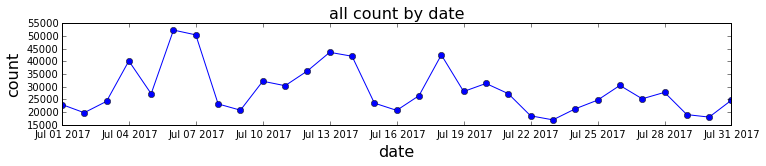

In [111]:
import matplotlib.pyplot as plt
from datetime import datetime

x_day=[datetime.strptime(d,'%Y-%m-%d').date() for d in day_waybill_count['create_date']]
y_day=day_waybill_count['count']

plt.subplot(2, 1, 1)
plt.plot(x_day, y_day, 'o-')

plt.xlabel('date', fontsize=16)  
plt.ylabel('count', fontsize=16)  
plt.title('all count by date ', fontsize=16)  

plt.show() 

In [93]:
day_waybill_count.head(100)

,create_date,count
0,2017-07-01,23000
1,2017-07-02,19764
2,2017-07-03,24252
3,2017-07-04,40180
4,2017-07-05,27236
5,2017-07-06,52348
6,2017-07-07,50454
7,2017-07-08,23227
8,2017-07-09,20760
9,2017-07-10,32183


In [112]:
hour_waybill_count.head(30)

,create_hour,count
0,0,18281
1,1,8027
2,2,4372
3,3,3054
4,4,2781
5,5,6230
6,6,17811
7,7,45348
8,8,71693
9,9,58371


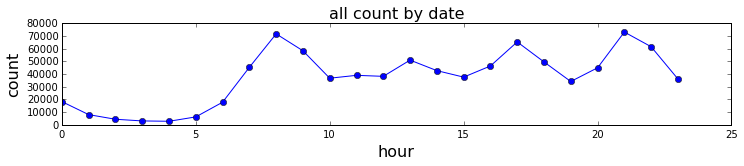

In [113]:
import matplotlib.pyplot as plt
from datetime import datetime

x_hour=hour_waybill_count['create_hour']
y_hour=hour_waybill_count['count']

plt.subplot(2, 1, 1)
plt.plot(x_hour, y_hour, 'o-')

plt.xlabel('hour', fontsize=16)  
plt.ylabel('count', fontsize=16)  
plt.title('all count by date ', fontsize=16)  

plt.show() 